## 5.4 단순한 계층 구현하기

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x =x 
        self.y = y
        out = x*y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다.
        dy = dout * self.x
        return dx, dy
    
    

### 5.4.2 덧셈 계층

In [3]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x,y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout + 1
        dy = dout + 1
        return dx, dy
    
    

## 5.5 활성화 함수 계층 구현하기
### 5.5.1 ReLU 계층

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self,x):
        self.mask = (x <=0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] =0 
        dx = dout
        
        return dx
    
    
        

In [5]:

x = np.array([[1.0,-0.5],[-2.0,3.0]])
mask = (x <=0)
mask

array([[False,  True],
       [ True, False]])

### 5.5.2 Sigmoid 계층

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out)*self.out
        return dx
    

## 5.6 Affine/Softmax 계층 구현하기
### 5.6.2 배치용 Affine 계층

In [7]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx
    
    

### 5.6.3 Softmax-with-Loss 계층

In [8]:
from common.functions import sigmoid, softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None  # softmax의 출력
        self.t = None # 정답 레이블(원-핫 벡터)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

### 5.7.2 오차역전파법을 적용한 신경망 구성하기

In [20]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b2"] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    # x : 입력데이터, t: 정답 테이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])

        return accuracy

    # x : 입력데이터, t: 정답 테이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        # print("dout: ",dout)

        layers = list(self.layers.values())
        layers.reverse()
        
        # print("layers: ",layers)
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads["b1"] = self.layers["Affine1"].db
        grads['W2'] = self.layers['Affine2'].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads

### 5.7.3 오차역전파법으로 구한 기울기 검증하기

In [13]:
# 데이터 읽기
from dataset.mnist import MnistDataloader
mnist_dataloader = MnistDataloader()
(x_train, t_train), (x_test, t_test) = mnist_dataloader.load_data()

network  = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 차이의 절댓값을 구한 후 , 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

dout:  [[ 0.0322041   0.02397916  0.00887233  0.01624798  0.00543078 -0.3299863
   0.00747505  0.02227968  0.15878274  0.05471448]
 [-0.31636094  0.0602203   0.02189726  0.0256337   0.00278514  0.00160508
   0.03126957  0.02814366  0.0372932   0.10751303]
 [ 0.01323507  0.03414394  0.03001472  0.03957432 -0.29754797  0.04359689
   0.02629214  0.01278366  0.01071262  0.08719462]]
layers:  [<common.layers.Affine object at 0x0000018FE10875F0>, <common.layers.Relu object at 0x0000018FE10841D0>, <common.layers.Affine object at 0x0000018FE1085F10>]
W1:5.682960733996064e-07
b1:1.4765834882605674e-08
W2:7.01929351754543e-06
b2:7.496378241336754e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [26]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기를 구한다
    grad = network.gradient(x_batch, t_batch)
    # print("grad[W1]: ",np.count_nonzero(grad['W1']))
    # print("grad['b1']: ",grad['b1'])
    # print("grad['W2']: ",grad['W2'])
    # print("grad['b2']: ",grad['b2'])

    # 갱신
    for key in ('W1', 'b1', 'W2','b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    # print("loss: ",loss)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        print("loss: ",loss)

        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train_acc, test_acc: ", train_acc, test_acc)

600.0
loss:  2.1280270923152655
train_acc, test_acc:  0.17256666666666667 0.1681
loss:  0.1609668918084821
train_acc, test_acc:  0.93295 0.9333
loss:  0.08874712844462185
train_acc, test_acc:  0.9488833333333333 0.9481
loss:  0.1453048531760147
train_acc, test_acc:  0.9567833333333333 0.9552
loss:  0.034035487694118294
train_acc, test_acc:  0.9589833333333333 0.9574
loss:  0.03966934924316089
train_acc, test_acc:  0.9694 0.9645
loss:  0.043413430221357185
train_acc, test_acc:  0.9712333333333333 0.9642
loss:  0.015820149856419892
train_acc, test_acc:  0.9721666666666666 0.9651
loss:  0.044880023651882074
train_acc, test_acc:  0.97665 0.9671
loss:  0.019155264588043345
train_acc, test_acc:  0.97755 0.9701
loss:  0.03560590069028405
train_acc, test_acc:  0.9797833333333333 0.9687
loss:  0.02568626763240974
train_acc, test_acc:  0.9818333333333333 0.971
loss:  0.01363722942062323
train_acc, test_acc:  0.9805666666666667 0.9715
loss:  0.013777476961935037
train_acc, test_acc:  0.9844833333

## 6.2 가중치의 초깃값
### 6.6.2 은닉층의 활성화값 분포

<Axes: >

Text(0.5, 1.0, '1-layer')

(array([  52.,  398.,  955., 1669., 2276., 2819., 3391., 3855., 4204.,
        4607., 4875., 4982., 5250., 5284., 5400., 5396., 5331., 5164.,
        5036., 4724., 4542., 4223., 3854., 3367., 2883., 2283., 1682.,
         999.,  436.,   63.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

<Axes: >

Text(0.5, 1.0, '2-layer')

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00,
        1.3100e+02, 5.8900e+02, 1.4120e+03, 2.3210e+03, 3.1610e+03,
        4.3510e+03, 5.7620e+03, 7.0470e+03, 8.8510e+03, 1.0466e+04,
        1.1076e+04, 1.0251e+04, 8.9560e+03, 7.3050e+03, 5.9780e+03,
        4.7500e+03, 3.6920e+03, 2.4040e+03, 1.1580e+03, 3.0100e+02,
        3.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

<Axes: >

Text(0.5, 1.0, '3-layer')

(array([    0.,     0.,     0.,     0.,     0.,     0.,   146.,  1814.,
         1781.,  1170.,  3686.,  9388.,  6594.,  6791.,  8877.,  9920.,
        11671., 15923.,  9074.,  4617.,  1554.,  2672.,  1616.,  1683.,
          609.,   414.,     0.,     0.,     0.,     0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

<Axes: >

Text(0.5, 1.0, '4-layer')

(array([    0.,     0.,     0.,     0.,     0.,     0.,   395.,  1471.,
         2134.,  8067.,  9707.,  8385., 10874.,  8884.,  4648., 11618.,
         6896.,  3042.,  8703.,  7031.,  3080.,  5065.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

<Axes: >

Text(0.5, 1.0, '5-layer')

(array([    0.,     0.,     0.,     0.,     0.,  1000.,  1000.,     0.,
            0.,  4911.,  6100., 11630.,  6341.,  8231.,  7807., 11980.,
         6000.,  6000., 11990.,  6593.,  4417.,  2642.,  1358.,   598.,
          402.,  1000.,     0.,     0.,     0.,     0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

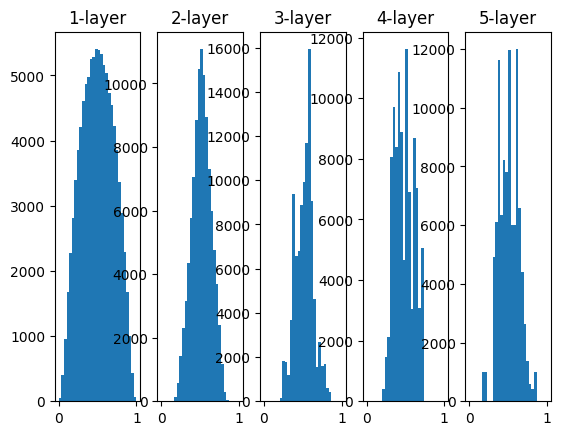

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) #1000개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과(활성화값)를 저장


for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01 # 가중치 표준편차 0.01
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # Xaiver 초깃값
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z


# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### 6.4.3 드롭아웃

In [38]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg = True):
        if train_flg: # 훈련 시
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else: # 추론
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask
    

np.float64(0.29354876682741304)